# Libraries:

In [2]:
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

In [4]:
from IPython.display import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import random

import os
from PIL import Image

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import load_model

from torch_lr_finder import LRFinder

In [5]:
# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset, and Preprocessing:

In [6]:
image_dataset = ImageFolder(root=r"C:\Users\annotated_dataset")

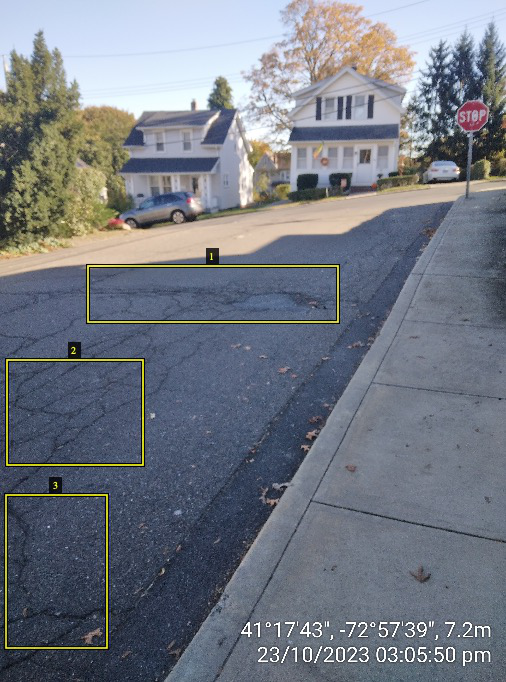

In [14]:
image_dataset[42][0]  #Here we upload complete Dataset, which is 200 images

In [16]:
#Here purpose of applying Transforms is to convert original images of Training set into Tensors to calcilate MEAN and STANDARD-
#DEVIATION of original images dimensions
training_data_transforms_for_mean_std = transforms.Compose([transforms.ToTensor()])  

In [17]:
#Conversion of Training set to Tensors, in order to calculate MEAN and STANDARD DEVIATION of Training set 
training_dataset = ImageFolder(root=r"C:\Users\annotated_dataset\training set",
                        transform=training_data_transforms_for_mean_std)

In [18]:
mean = 0.0
for img, _ in training_dataset:
    mean += img.mean([1,2])
mean = mean/len(training_dataset)
print(mean)

tensor([0.4529, 0.4755, 0.4966])


In [19]:
sumel = 0.0
countel = 0
for img, _ in training_dataset:
    img = (img - mean.unsqueeze(1).unsqueeze(1))**2
    sumel += img.sum([1, 2])
    countel += torch.numel(img[0])
std = torch.sqrt(sumel/countel)
print(std)

tensor([0.2335, 0.2292, 0.2360])


In [20]:
#Main Transorms
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((32,32)),
                                transforms.RandomHorizontalFlip(),
                                transforms.Normalize((mean), (std))
                               ])

NOTE: 
     NOW, As For Training-set we use just 2 images (as mentioned in the requirements)

In [21]:
#Applying Transforms to Training dataset 
train_set = ImageFolder(root=r"C:\Users\annotated_dataset\training set",transform=transform)

In [22]:
#Applying Transforms to Validation dataset
validation_set = ImageFolder(root=r"C:\Users\annotated_dataset\validation set",transform=transform)

In [23]:
#Applying Transforms to Test dataset 
test_set = ImageFolder(root=r"C:\Users\annotated_dataset\test set",transform=transform)

# Data Loaders:

In [24]:
#Initialization of dataloader
train_loader      = DataLoader(train_set     , batch_size = 2 , shuffle = True)
validation_loader = DataLoader(validation_set, batch_size = 2 , shuffle = True)
test_loader       = DataLoader(test_set      , batch_size = 2 , shuffle = True)

# Model:

In [27]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(CustomCNN, self).__init__()
        
        # Convolutional layers with Kaiming initialization
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv1.bias)
        
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        nn.init.zeros_(self.conv2.bias)
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Linear layers with normal initialization
        self.fc1 = nn.Linear(32 * 8 * 8, 8)
        nn.init.normal_(self.fc1.weight, num_classes) 
        nn.init.zeros_(self.fc1.bias)
        
        self.fc2 = nn.Linear(8, num_classes)
        nn.init.normal_(self.fc2.weight, num_classes) 
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = nn.functional.relu(self.conv1(x))
        x = nn.functional.max_pool2d(x, 2)
        x = nn.functional.relu(self.conv2(x))
        x = nn.functional.max_pool2d(x, 2)
        x = self.flatten(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Hper-Parameters:

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\khalil\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.78E-07


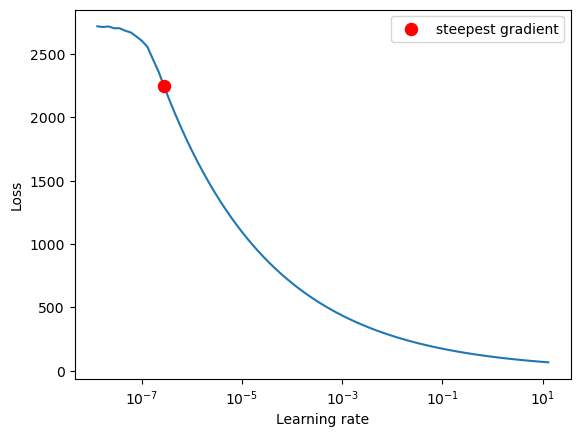

(<Axes: xlabel='Learning rate', ylabel='Loss'>, 2.782559402207124e-07)

In [28]:
#Model assigning
model = CustomCNN()

# Setting Loss function 
criterion = nn.CrossEntropyLoss()

# Setting optimizer with Initial Parameter values
optimizer = torch.optim.SGD(model.parameters(), lr=1e-9, weight_decay = 0.009, momentum = 0.9)  

# Library used to Find good Learning Rate
lr_finder = LRFinder(model, optimizer, criterion, device="cpu")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot()  


# Training:

In [31]:
# Choosed learning rate from plot, where the loss decrease
chosen_lr = 0.000000278  

# Momentum values that we will try 
momentum_values = [0.1, 0.6, 0.9]

# Weight decay values that we will try
weight_decay_values = [1e-4, 1e-5, 1e-6]

# Lists to store training and validation losses
train_losses = []
validation_losses = []

# Training loop for different momentum and weight decay values
for momentum in momentum_values:
    for weight_decay in weight_decay_values:
        model = CustomCNN()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.SGD(model.parameters(), lr=chosen_lr, momentum=momentum, weight_decay=weight_decay)

        num_epochs = 5  

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            for images, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
        
            # Calculating average training loss for the epochs
            avg_train_loss = running_loss / len(train_loader)
            train_losses.append(avg_train_loss)

            # Validation loop
            model.eval()
            validation_loss = 0.0
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in validation_loader:
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    validation_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
            # Calculating average validation loss for the epochs
            avg_validation_loss = validation_loss / len(validation_loader)
            validation_losses.append(avg_validation_loss)

            print(f'Momentum: {momentum}, Weight Decay: {weight_decay}, Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}, Validation Accuracy: {(correct / total) * 100:.2f}%')


Momentum: 0.1, Weight Decay: 0.0001, Epoch [1/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 0.0001, Epoch [2/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 0.0001, Epoch [3/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 0.0001, Epoch [4/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 0.0001, Epoch [5/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 1e-05, Epoch [1/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 1e-05, Epoch [2/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 1e-05, Epoch [3/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 1e-05, Epoch [4/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 1e-05, Epoch [5/5], Loss: 0.0000, Validation Accuracy: 100.00%
Momentum: 0.1, Weight Decay: 1e-06, Epoch [1/5], Loss: 0.0000, Validation A

# Losses:

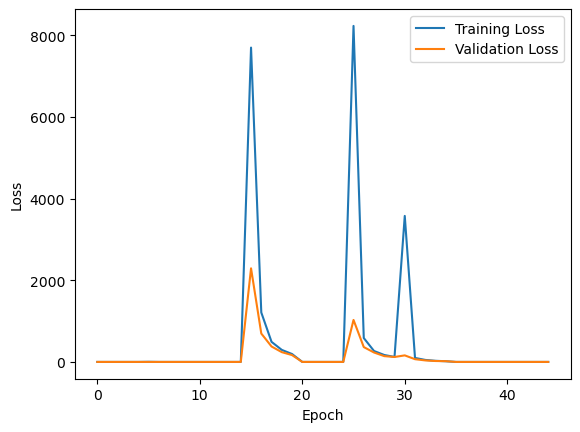

In [33]:
# Plotting the training and validation losses
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# EVALUATION:

In [34]:
# Testing the model
model.eval()
test_correct = 0
test_total = 0
with torch.no_grad():
    for inputs, labels in test_loader:  #Test set
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()

print(f'Test Accuracy: {(test_correct / test_total) * 100:.2f}%')

Test Accuracy: 100.00%


NOTE: As we also use RayTune Library for Hyper-Paramters selection but it takes too much time and output will not achieved thats why we stop that approach

# Hyper - Paramters Exploration (RayTune):

In [39]:
from ray import train, tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.schedulers import AsyncHyperBandScheduler
import os

import torch.optim as optim

In [55]:
# Lists to store training and validation losses
train_losses = []
validation_losses = []
# Define a training function
def train_cnn(config, checkpoint_dir=None, data_dir=None):
    model = CustomCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"], weight_decay=config["weight_decay"])

    # Data loading
    #Applying Transforms to Training dataset 
    train_set = ImageFolder(root=r"C:\Users\annotated_dataset\training set",transform=transform)
    train_loader = DataLoader(train_set     , batch_size = 2 , shuffle = True)

    #Applying Transforms to Validation dataset
    validation_set = ImageFolder(root=r"C:\Users\annotated_dataset\validation set",transform=transform)
    validation_loader = DataLoader(validation_set, batch_size = 2 , shuffle = False)


    # Training loop
    for epoch in range(1):  
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            inputs, labels = batch
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            #running_loss += loss.item()
            
        # Calculate average training loss for the epoch
        #avg_train_loss = running_loss / len(train_loader)
       # train_losses.append(avg_train_loss)

    # Validation
    #validation_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in validation_loader:
            inputs, labels = batch
            outputs = model(inputs)
            #loss = criterion(outputs, labels)
           # validation_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculate average validation loss for the epoch
    #avg_validation_loss = validation_loss / len(validation_loader)
    #validation_losses.append(avg_validation_loss)
    
    accuracy = correct / total
    
    #  metrics for hyperparameter tuning
    tune.report(accuracy=accuracy, other_metric1=value1, other_metric2=value2)

    return accuracy




In [56]:
# Hyperparameter search space
search_space = {
    "lr": tune.loguniform(1e-4, 1e-1),
    "momentum": tune.uniform(0.0, 1.0),
    "weight_decay": tune.loguniform(1e-6, 1e-3)
}

In [57]:
# Ray Tune configuration
config = {
    "num_samples": 2,  # Number of hyperparameter samples to try
    "config": search_space,
    "stop": {"accuracy": 0.95},  # Stop tuning when accuracy reaches 95%
    "local_dir": "./ray_results",  # Directory to store results
    "resources_per_trial": {"cpu": 1, "gpu": 0},
}


In [58]:
#Setting ASHA scheduler with a maximum of  epochs
scheduler = ASHAScheduler(metric="accuracy", mode="max", max_t=2, grace_period=1)  #10

#Setting reporter for logging
reporter = CLIReporter()


In [ ]:
#Hyperparameter tuning
analysis = tune.run(
    train_cnn,
    name="hyperparameter_tuning",
    num_samples=config["num_samples"],
    config=config["config"],
    stop=config["stop"],
    local_dir=config["local_dir"],
    resources_per_trial=config["resources_per_trial"],
    scheduler=scheduler,
    progress_reporter=reporter
)


== Status ==
Current time: 2023-11-23 16:22:00 (running for 00:00:05.20)
Memory usage on this node: 6.6/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:22:05 (running for 00:00:10

== Status ==
Current time: 2023-11-23 16:22:45 (running for 00:00:50.71)
Memory usage on this node: 6.6/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:22:50 (running for 00:00:55

== Status ==
Current time: 2023-11-23 16:23:31 (running for 00:01:36.30)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:23:36 (running for 00:01:41

== Status ==
Current time: 2023-11-23 16:24:16 (running for 00:02:21.85)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:24:22 (running for 00:02:26

== Status ==
Current time: 2023-11-23 16:25:02 (running for 00:03:07.33)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:25:07 (running for 00:03:12

== Status ==
Current time: 2023-11-23 16:25:47 (running for 00:03:52.83)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:25:53 (running for 00:03:57

== Status ==
Current time: 2023-11-23 16:26:33 (running for 00:04:38.35)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:26:38 (running for 00:04:43

== Status ==
Current time: 2023-11-23 16:27:19 (running for 00:05:23.88)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:27:24 (running for 00:05:28

== Status ==
Current time: 2023-11-23 16:28:04 (running for 00:06:09.41)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:28:09 (running for 00:06:14

== Status ==
Current time: 2023-11-23 16:28:50 (running for 00:06:54.87)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:28:55 (running for 00:06:59

== Status ==
Current time: 2023-11-23 16:29:35 (running for 00:07:40.36)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:29:40 (running for 00:07:45

== Status ==
Current time: 2023-11-23 16:30:20 (running for 00:08:25.82)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:30:26 (running for 00:08:31

== Status ==
Current time: 2023-11-23 16:31:07 (running for 00:09:12.66)
Memory usage on this node: 6.4/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:31:13 (running for 00:09:17

== Status ==
Current time: 2023-11-23 16:31:54 (running for 00:09:59.46)
Memory usage on this node: 6.4/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:31:59 (running for 00:10:04

== Status ==
Current time: 2023-11-23 16:32:41 (running for 00:10:45.92)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:32:46 (running for 00:10:51

== Status ==
Current time: 2023-11-23 16:33:26 (running for 00:11:31.82)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:33:32 (running for 00:11:36

== Status ==
Current time: 2023-11-23 16:34:13 (running for 00:12:18.22)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:34:18 (running for 00:12:23

== Status ==
Current time: 2023-11-23 16:34:59 (running for 00:13:04.48)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:35:04 (running for 00:13:09

== Status ==
Current time: 2023-11-23 16:35:46 (running for 00:13:51.40)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:35:51 (running for 00:13:56

== Status ==
Current time: 2023-11-23 16:36:34 (running for 00:14:39.18)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:36:39 (running for 00:14:44

== Status ==
Current time: 2023-11-23 16:37:20 (running for 00:15:24.93)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:37:25 (running for 00:15:29

== Status ==
Current time: 2023-11-23 16:38:05 (running for 00:16:10.75)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:38:11 (running for 00:16:16

== Status ==
Current time: 2023-11-23 16:38:52 (running for 00:16:57.40)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:38:57 (running for 00:17:02

== Status ==
Current time: 2023-11-23 16:39:39 (running for 00:17:44.35)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:39:44 (running for 00:17:49

== Status ==
Current time: 2023-11-23 16:40:25 (running for 00:18:30.19)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:40:30 (running for 00:18:35

== Status ==
Current time: 2023-11-23 16:41:11 (running for 00:19:16.09)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:41:16 (running for 00:19:21

== Status ==
Current time: 2023-11-23 16:41:57 (running for 00:20:02.44)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:42:03 (running for 00:20:08

== Status ==
Current time: 2023-11-23 16:42:44 (running for 00:20:49.51)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:42:49 (running for 00:20:54

== Status ==
Current time: 2023-11-23 16:43:30 (running for 00:21:35.46)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:43:35 (running for 00:21:40

== Status ==
Current time: 2023-11-23 16:44:16 (running for 00:22:21.30)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:44:21 (running for 00:22:26

== Status ==
Current time: 2023-11-23 16:45:03 (running for 00:23:08.58)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:45:08 (running for 00:23:13

== Status ==
Current time: 2023-11-23 16:45:50 (running for 00:23:54.90)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:45:55 (running for 00:23:59

== Status ==
Current time: 2023-11-23 16:46:36 (running for 00:24:41.81)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:46:42 (running for 00:24:46

== Status ==
Current time: 2023-11-23 16:47:22 (running for 00:25:27.40)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:47:27 (running for 00:25:32

== Status ==
Current time: 2023-11-23 16:48:08 (running for 00:26:12.93)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:48:13 (running for 00:26:18

== Status ==
Current time: 2023-11-23 16:48:53 (running for 00:26:58.70)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:48:58 (running for 00:27:03

== Status ==
Current time: 2023-11-23 16:49:39 (running for 00:27:44.24)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:49:44 (running for 00:27:49

== Status ==
Current time: 2023-11-23 16:50:25 (running for 00:28:29.85)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:50:30 (running for 00:28:34

== Status ==
Current time: 2023-11-23 16:51:10 (running for 00:29:15.39)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:51:15 (running for 00:29:20

== Status ==
Current time: 2023-11-23 16:51:56 (running for 00:30:00.98)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:52:01 (running for 00:30:06

== Status ==
Current time: 2023-11-23 16:52:41 (running for 00:30:46.53)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:52:46 (running for 00:30:51

== Status ==
Current time: 2023-11-23 16:53:27 (running for 00:31:32.07)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:53:32 (running for 00:31:37

== Status ==
Current time: 2023-11-23 16:54:12 (running for 00:32:17.68)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:54:17 (running for 00:32:22

== Status ==
Current time: 2023-11-23 16:54:58 (running for 00:33:03.25)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:55:03 (running for 00:33:08

== Status ==
Current time: 2023-11-23 16:55:43 (running for 00:33:48.83)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:55:49 (running for 00:33:53

== Status ==
Current time: 2023-11-23 16:56:29 (running for 00:34:34.37)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:56:34 (running for 00:34:39

== Status ==
Current time: 2023-11-23 16:57:15 (running for 00:35:19.88)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:57:20 (running for 00:35:24

== Status ==
Current time: 2023-11-23 16:58:00 (running for 00:36:05.46)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:58:05 (running for 00:36:10

== Status ==
Current time: 2023-11-23 16:58:46 (running for 00:36:51.07)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:58:51 (running for 00:36:56

== Status ==
Current time: 2023-11-23 16:59:31 (running for 00:37:36.61)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 16:59:36 (running for 00:37:41

== Status ==
Current time: 2023-11-23 17:00:17 (running for 00:38:22.19)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:00:22 (running for 00:38:27

== Status ==
Current time: 2023-11-23 17:01:02 (running for 00:39:07.73)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:01:07 (running for 00:39:12

== Status ==
Current time: 2023-11-23 17:01:48 (running for 00:39:53.30)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:01:53 (running for 00:39:58

== Status ==
Current time: 2023-11-23 17:02:33 (running for 00:40:38.83)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:02:39 (running for 00:40:43

== Status ==
Current time: 2023-11-23 17:03:19 (running for 00:41:24.42)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:03:24 (running for 00:41:29

== Status ==
Current time: 2023-11-23 17:04:05 (running for 00:42:10.00)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:04:10 (running for 00:42:15

== Status ==
Current time: 2023-11-23 17:04:50 (running for 00:42:55.60)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:04:55 (running for 00:43:00

== Status ==
Current time: 2023-11-23 17:05:36 (running for 00:43:41.12)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:05:41 (running for 00:43:46

== Status ==
Current time: 2023-11-23 17:06:21 (running for 00:44:26.67)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:06:26 (running for 00:44:31

== Status ==
Current time: 2023-11-23 17:07:07 (running for 00:45:12.22)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:07:12 (running for 00:45:17

== Status ==
Current time: 2023-11-23 17:07:52 (running for 00:45:57.77)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:07:57 (running for 00:46:02

== Status ==
Current time: 2023-11-23 17:08:38 (running for 00:46:43.31)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:08:43 (running for 00:46:48

== Status ==
Current time: 2023-11-23 17:09:24 (running for 00:47:28.89)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:09:29 (running for 00:47:33

== Status ==
Current time: 2023-11-23 17:10:09 (running for 00:48:14.44)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:10:14 (running for 00:48:19

== Status ==
Current time: 2023-11-23 17:10:55 (running for 00:48:59.96)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:11:00 (running for 00:49:05

== Status ==
Current time: 2023-11-23 17:11:40 (running for 00:49:45.48)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:11:45 (running for 00:49:50

== Status ==
Current time: 2023-11-23 17:12:26 (running for 00:50:31.01)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:12:31 (running for 00:50:36

== Status ==
Current time: 2023-11-23 17:13:11 (running for 00:51:16.56)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:13:16 (running for 00:51:21

== Status ==
Current time: 2023-11-23 17:13:57 (running for 00:52:02.11)
Memory usage on this node: 6.3/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:14:02 (running for 00:52:07

== Status ==
Current time: 2023-11-23 17:14:42 (running for 00:52:47.58)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:14:47 (running for 00:52:52

== Status ==
Current time: 2023-11-23 17:15:28 (running for 00:53:33.10)
Memory usage on this node: 6.2/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:15:33 (running for 00:53:38

== Status ==
Current time: 2023-11-23 17:16:13 (running for 00:54:18.61)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:16:18 (running for 00:54:23

== Status ==
Current time: 2023-11-23 17:16:59 (running for 00:55:04.15)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:17:04 (running for 00:55:09

== Status ==
Current time: 2023-11-23 17:17:44 (running for 00:55:49.67)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:17:49 (running for 00:55:54

== Status ==
Current time: 2023-11-23 17:18:30 (running for 00:56:35.22)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:18:35 (running for 00:56:40

== Status ==
Current time: 2023-11-23 17:19:15 (running for 00:57:20.77)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:19:20 (running for 00:57:25

== Status ==
Current time: 2023-11-23 17:20:01 (running for 00:58:06.29)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:20:06 (running for 00:58:11

== Status ==
Current time: 2023-11-23 17:20:46 (running for 00:58:51.78)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:20:51 (running for 00:58:56

== Status ==
Current time: 2023-11-23 17:21:32 (running for 00:59:37.32)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:21:37 (running for 00:59:42

== Status ==
Current time: 2023-11-23 17:22:17 (running for 01:00:22.82)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:22:23 (running for 01:00:27

== Status ==
Current time: 2023-11-23 17:23:03 (running for 01:01:08.35)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:23:08 (running for 01:01:13

== Status ==
Current time: 2023-11-23 17:23:49 (running for 01:01:53.86)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:23:54 (running for 01:01:58

== Status ==
Current time: 2023-11-23 17:24:34 (running for 01:02:39.38)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:24:39 (running for 01:02:44

== Status ==
Current time: 2023-11-23 17:25:20 (running for 01:03:24.90)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:25:25 (running for 01:03:29

== Status ==
Current time: 2023-11-23 17:26:05 (running for 01:04:10.46)
Memory usage on this node: 6.1/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:26:10 (running for 01:04:15

== Status ==
Current time: 2023-11-23 17:26:51 (running for 01:04:55.97)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:26:56 (running for 01:05:01

== Status ==
Current time: 2023-11-23 17:27:36 (running for 01:05:41.51)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:27:41 (running for 01:05:46

== Status ==
Current time: 2023-11-23 17:28:22 (running for 01:06:27.01)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:28:27 (running for 01:06:32

== Status ==
Current time: 2023-11-23 17:29:07 (running for 01:07:12.52)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:29:12 (running for 01:07:17

== Status ==
Current time: 2023-11-23 17:29:53 (running for 01:07:58.10)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:29:58 (running for 01:08:03

== Status ==
Current time: 2023-11-23 17:30:38 (running for 01:08:43.65)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:30:43 (running for 01:08:48

== Status ==
Current time: 2023-11-23 17:31:24 (running for 01:09:29.21)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:31:29 (running for 01:09:34

== Status ==
Current time: 2023-11-23 17:32:09 (running for 01:10:14.75)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:32:14 (running for 01:10:19

== Status ==
Current time: 2023-11-23 17:32:55 (running for 01:11:00.32)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:33:00 (running for 01:11:05

== Status ==
Current time: 2023-11-23 17:33:41 (running for 01:11:45.85)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:33:46 (running for 01:11:50

== Status ==
Current time: 2023-11-23 17:34:26 (running for 01:12:31.36)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:34:31 (running for 01:12:36

== Status ==
Current time: 2023-11-23 17:35:12 (running for 01:13:16.89)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:35:17 (running for 01:13:21

== Status ==
Current time: 2023-11-23 17:35:57 (running for 01:14:02.43)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:36:02 (running for 01:14:07

== Status ==
Current time: 2023-11-23 17:36:43 (running for 01:14:47.99)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:36:48 (running for 01:14:53

== Status ==
Current time: 2023-11-23 17:37:28 (running for 01:15:33.50)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:37:33 (running for 01:15:38

== Status ==
Current time: 2023-11-23 17:38:14 (running for 01:16:19.07)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:38:19 (running for 01:16:24

== Status ==
Current time: 2023-11-23 17:38:59 (running for 01:17:04.64)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:39:04 (running for 01:17:09

== Status ==
Current time: 2023-11-23 17:39:45 (running for 01:17:50.18)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:39:50 (running for 01:17:55

== Status ==
Current time: 2023-11-23 17:40:30 (running for 01:18:35.72)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:40:35 (running for 01:18:40

== Status ==
Current time: 2023-11-23 17:41:16 (running for 01:19:21.25)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:41:21 (running for 01:19:26

== Status ==
Current time: 2023-11-23 17:42:02 (running for 01:20:06.87)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:42:07 (running for 01:20:11

== Status ==
Current time: 2023-11-23 17:42:47 (running for 01:20:52.46)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:42:52 (running for 01:20:57

== Status ==
Current time: 2023-11-23 17:43:33 (running for 01:21:38.03)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:43:38 (running for 01:21:43

== Status ==
Current time: 2023-11-23 17:44:18 (running for 01:22:23.59)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:44:23 (running for 01:22:28

== Status ==
Current time: 2023-11-23 17:45:04 (running for 01:23:09.11)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:45:09 (running for 01:23:14

== Status ==
Current time: 2023-11-23 17:45:50 (running for 01:23:55.38)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:45:55 (running for 01:24:00

== Status ==
Current time: 2023-11-23 17:46:36 (running for 01:24:40.96)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:46:41 (running for 01:24:46

== Status ==
Current time: 2023-11-23 17:47:21 (running for 01:25:26.52)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:47:26 (running for 01:25:31

== Status ==
Current time: 2023-11-23 17:48:07 (running for 01:26:12.12)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:48:12 (running for 01:26:17

== Status ==
Current time: 2023-11-23 17:48:52 (running for 01:26:57.73)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:48:57 (running for 01:27:02

== Status ==
Current time: 2023-11-23 17:49:38 (running for 01:27:43.35)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:49:43 (running for 01:27:48

== Status ==
Current time: 2023-11-23 17:50:24 (running for 01:28:28.92)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:50:29 (running for 01:28:33

== Status ==
Current time: 2023-11-23 17:51:09 (running for 01:29:14.45)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:51:14 (running for 01:29:19

== Status ==
Current time: 2023-11-23 17:51:55 (running for 01:30:00.09)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:52:00 (running for 01:30:05

== Status ==
Current time: 2023-11-23 17:52:40 (running for 01:30:45.66)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:52:45 (running for 01:30:50

== Status ==
Current time: 2023-11-23 17:53:26 (running for 01:31:31.20)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:53:31 (running for 01:31:36

== Status ==
Current time: 2023-11-23 17:54:12 (running for 01:32:16.87)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:54:17 (running for 01:32:21

== Status ==
Current time: 2023-11-23 17:54:57 (running for 01:33:02.42)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:55:02 (running for 01:33:07

== Status ==
Current time: 2023-11-23 17:55:43 (running for 01:33:47.94)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:55:48 (running for 01:33:53

== Status ==
Current time: 2023-11-23 17:56:28 (running for 01:34:33.47)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:56:33 (running for 01:34:38

== Status ==
Current time: 2023-11-23 17:57:14 (running for 01:35:19.02)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:57:19 (running for 01:35:24

== Status ==
Current time: 2023-11-23 17:57:59 (running for 01:36:04.58)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:58:04 (running for 01:36:09

== Status ==
Current time: 2023-11-23 17:58:45 (running for 01:36:50.10)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:58:50 (running for 01:36:55

== Status ==
Current time: 2023-11-23 17:59:30 (running for 01:37:35.68)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 17:59:35 (running for 01:37:40

== Status ==
Current time: 2023-11-23 18:00:16 (running for 01:38:21.22)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:00:21 (running for 01:38:26

== Status ==
Current time: 2023-11-23 18:01:01 (running for 01:39:06.79)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:01:07 (running for 01:39:11

== Status ==
Current time: 2023-11-23 18:01:47 (running for 01:39:52.32)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:01:52 (running for 01:39:57

== Status ==
Current time: 2023-11-23 18:02:32 (running for 01:40:37.82)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:02:38 (running for 01:40:42

== Status ==
Current time: 2023-11-23 18:03:18 (running for 01:41:23.38)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:03:23 (running for 01:41:28

== Status ==
Current time: 2023-11-23 18:04:04 (running for 01:42:08.92)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:04:09 (running for 01:42:13

== Status ==
Current time: 2023-11-23 18:04:49 (running for 01:42:54.43)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:04:54 (running for 01:42:59

== Status ==
Current time: 2023-11-23 18:05:35 (running for 01:43:39.95)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:05:40 (running for 01:43:45

== Status ==
Current time: 2023-11-23 18:06:20 (running for 01:44:25.48)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:06:25 (running for 01:44:30

== Status ==
Current time: 2023-11-23 18:07:06 (running for 01:45:10.97)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:07:11 (running for 01:45:16

== Status ==
Current time: 2023-11-23 18:07:51 (running for 01:45:56.50)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:07:56 (running for 01:46:01

== Status ==
Current time: 2023-11-23 18:08:37 (running for 01:46:42.05)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:08:42 (running for 01:46:47

== Status ==
Current time: 2023-11-23 18:09:22 (running for 01:47:27.58)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:09:27 (running for 01:47:32

== Status ==
Current time: 2023-11-23 18:10:08 (running for 01:48:13.09)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:10:13 (running for 01:48:18

== Status ==
Current time: 2023-11-23 18:10:53 (running for 01:48:58.61)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:10:58 (running for 01:49:03

== Status ==
Current time: 2023-11-23 18:11:39 (running for 01:49:44.14)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:11:44 (running for 01:49:49

== Status ==
Current time: 2023-11-23 18:12:24 (running for 01:50:29.71)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:12:29 (running for 01:50:34

== Status ==
Current time: 2023-11-23 18:13:10 (running for 01:51:15.24)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:13:15 (running for 01:51:20

== Status ==
Current time: 2023-11-23 18:13:55 (running for 01:52:00.78)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:14:00 (running for 01:52:05

== Status ==
Current time: 2023-11-23 18:14:41 (running for 01:52:46.32)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:14:46 (running for 01:52:51

== Status ==
Current time: 2023-11-23 18:15:27 (running for 01:53:31.93)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:15:32 (running for 01:53:36

== Status ==
Current time: 2023-11-23 18:16:12 (running for 01:54:17.51)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:16:17 (running for 01:54:22

== Status ==
Current time: 2023-11-23 18:16:58 (running for 01:55:03.03)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:17:03 (running for 01:55:08

== Status ==
Current time: 2023-11-23 18:17:43 (running for 01:55:48.60)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:17:48 (running for 01:55:53

== Status ==
Current time: 2023-11-23 18:18:29 (running for 01:56:34.17)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:18:34 (running for 01:56:39

== Status ==
Current time: 2023-11-23 18:19:14 (running for 01:57:19.72)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:19:19 (running for 01:57:24

== Status ==
Current time: 2023-11-23 18:20:00 (running for 01:58:05.27)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:20:05 (running for 01:58:10

== Status ==
Current time: 2023-11-23 18:20:45 (running for 01:58:50.82)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:20:51 (running for 01:58:55

== Status ==
Current time: 2023-11-23 18:21:31 (running for 01:59:36.37)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:21:36 (running for 01:59:41

== Status ==
Current time: 2023-11-23 18:22:17 (running for 02:00:21.86)
Memory usage on this node: 5.6/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:22:22 (running for 02:00:26

== Status ==
Current time: 2023-11-23 18:23:02 (running for 02:01:07.38)
Memory usage on this node: 5.5/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:23:07 (running for 02:01:12

== Status ==
Current time: 2023-11-23 18:23:48 (running for 02:01:53.02)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:23:53 (running for 02:01:58

== Status ==
Current time: 2023-11-23 18:24:33 (running for 02:02:38.55)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:24:38 (running for 02:02:43

== Status ==
Current time: 2023-11-23 18:25:19 (running for 02:03:24.09)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:25:24 (running for 02:03:29

== Status ==
Current time: 2023-11-23 18:26:04 (running for 02:04:09.59)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:26:09 (running for 02:04:14

== Status ==
Current time: 2023-11-23 18:26:50 (running for 02:04:55.16)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:26:55 (running for 02:05:00

== Status ==
Current time: 2023-11-23 18:27:35 (running for 02:05:40.68)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:27:40 (running for 02:05:45

== Status ==
Current time: 2023-11-23 18:28:21 (running for 02:06:26.27)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:28:26 (running for 02:06:31

== Status ==
Current time: 2023-11-23 18:29:06 (running for 02:07:11.79)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:29:11 (running for 02:07:16

== Status ==
Current time: 2023-11-23 18:29:52 (running for 02:07:57.29)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:29:57 (running for 02:08:02

== Status ==
Current time: 2023-11-23 18:30:37 (running for 02:08:42.77)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:30:42 (running for 02:08:47

== Status ==
Current time: 2023-11-23 18:31:23 (running for 02:09:28.33)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:31:28 (running for 02:09:33

== Status ==
Current time: 2023-11-23 18:32:08 (running for 02:10:13.83)
Memory usage on this node: 6.0/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:32:14 (running for 02:10:18

== Status ==
Current time: 2023-11-23 18:32:54 (running for 02:10:59.36)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:32:59 (running for 02:11:04

== Status ==
Current time: 2023-11-23 18:33:40 (running for 02:11:44.89)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:33:45 (running for 02:11:49

== Status ==
Current time: 2023-11-23 18:34:25 (running for 02:12:30.41)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:34:30 (running for 02:12:35

== Status ==
Current time: 2023-11-23 18:35:11 (running for 02:13:15.90)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:35:16 (running for 02:13:20

== Status ==
Current time: 2023-11-23 18:35:56 (running for 02:14:01.39)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:36:01 (running for 02:14:06

== Status ==
Current time: 2023-11-23 18:36:42 (running for 02:14:46.96)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:36:47 (running for 02:14:52

== Status ==
Current time: 2023-11-23 18:37:27 (running for 02:15:32.45)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:37:32 (running for 02:15:37

== Status ==
Current time: 2023-11-23 18:38:13 (running for 02:16:17.93)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:38:18 (running for 02:16:22

== Status ==
Current time: 2023-11-23 18:38:58 (running for 02:17:03.44)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:39:03 (running for 02:17:08

== Status ==
Current time: 2023-11-23 18:39:44 (running for 02:17:48.94)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:39:49 (running for 02:17:54

== Status ==
Current time: 2023-11-23 18:40:29 (running for 02:18:34.47)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:40:34 (running for 02:18:39

== Status ==
Current time: 2023-11-23 18:41:15 (running for 02:19:19.99)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:41:20 (running for 02:19:25

== Status ==
Current time: 2023-11-23 18:42:00 (running for 02:20:05.51)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:42:05 (running for 02:20:10

== Status ==
Current time: 2023-11-23 18:42:46 (running for 02:20:51.04)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:42:51 (running for 02:20:56

== Status ==
Current time: 2023-11-23 18:43:31 (running for 02:21:36.59)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:43:36 (running for 02:21:41

== Status ==
Current time: 2023-11-23 18:44:17 (running for 02:22:22.08)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:44:22 (running for 02:22:27

== Status ==
Current time: 2023-11-23 18:45:02 (running for 02:23:07.57)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:45:07 (running for 02:23:12

== Status ==
Current time: 2023-11-23 18:45:48 (running for 02:23:53.12)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:45:53 (running for 02:23:58

== Status ==
Current time: 2023-11-23 18:46:33 (running for 02:24:38.64)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:46:38 (running for 02:24:43

== Status ==
Current time: 2023-11-23 18:47:19 (running for 02:25:24.12)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:47:24 (running for 02:25:29

== Status ==
Current time: 2023-11-23 18:48:04 (running for 02:26:09.63)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:48:09 (running for 02:26:14

== Status ==
Current time: 2023-11-23 18:48:50 (running for 02:26:55.10)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:48:55 (running for 02:27:00

== Status ==
Current time: 2023-11-23 18:49:35 (running for 02:27:40.63)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:49:40 (running for 02:27:45

== Status ==
Current time: 2023-11-23 18:50:21 (running for 02:28:26.19)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:50:26 (running for 02:28:31

== Status ==
Current time: 2023-11-23 18:51:06 (running for 02:29:11.80)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:51:12 (running for 02:29:16

== Status ==
Current time: 2023-11-23 18:51:52 (running for 02:29:57.30)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:51:57 (running for 02:30:02

== Status ==
Current time: 2023-11-23 18:52:38 (running for 02:30:42.88)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:52:43 (running for 02:30:47

== Status ==
Current time: 2023-11-23 18:53:23 (running for 02:31:28.39)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:53:28 (running for 02:31:33

== Status ==
Current time: 2023-11-23 18:54:09 (running for 02:32:13.96)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:54:14 (running for 02:32:19

== Status ==
Current time: 2023-11-23 18:54:54 (running for 02:32:59.50)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:54:59 (running for 02:33:04

== Status ==
Current time: 2023-11-23 18:55:40 (running for 02:33:45.08)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:55:45 (running for 02:33:50

== Status ==
Current time: 2023-11-23 18:56:25 (running for 02:34:30.62)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:56:30 (running for 02:34:35

== Status ==
Current time: 2023-11-23 18:57:11 (running for 02:35:16.22)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:57:16 (running for 02:35:21

== Status ==
Current time: 2023-11-23 18:57:56 (running for 02:36:01.76)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:58:01 (running for 02:36:06

== Status ==
Current time: 2023-11-23 18:58:42 (running for 02:36:47.29)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:58:47 (running for 02:36:52

== Status ==
Current time: 2023-11-23 18:59:28 (running for 02:37:32.88)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 18:59:33 (running for 02:37:37

== Status ==
Current time: 2023-11-23 19:00:13 (running for 02:38:18.43)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:00:18 (running for 02:38:23

== Status ==
Current time: 2023-11-23 19:00:59 (running for 02:39:03.97)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:01:04 (running for 02:39:09

== Status ==
Current time: 2023-11-23 19:01:44 (running for 02:39:49.53)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:01:49 (running for 02:39:54

== Status ==
Current time: 2023-11-23 19:02:30 (running for 02:40:35.12)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:02:35 (running for 02:40:40

== Status ==
Current time: 2023-11-23 19:03:15 (running for 02:41:20.65)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:03:20 (running for 02:41:25

== Status ==
Current time: 2023-11-23 19:04:01 (running for 02:42:06.17)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:04:06 (running for 02:42:11

== Status ==
Current time: 2023-11-23 19:04:46 (running for 02:42:51.80)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:04:52 (running for 02:42:56

== Status ==
Current time: 2023-11-23 19:05:32 (running for 02:43:37.39)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:05:37 (running for 02:43:42

== Status ==
Current time: 2023-11-23 19:06:18 (running for 02:44:22.99)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:06:23 (running for 02:44:28

== Status ==
Current time: 2023-11-23 19:07:03 (running for 02:45:08.60)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:07:08 (running for 02:45:13

== Status ==
Current time: 2023-11-23 19:07:49 (running for 02:45:54.16)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:07:54 (running for 02:45:59

== Status ==
Current time: 2023-11-23 19:08:34 (running for 02:46:39.65)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:08:39 (running for 02:46:44

== Status ==
Current time: 2023-11-23 19:09:20 (running for 02:47:25.16)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:09:25 (running for 02:47:30

== Status ==
Current time: 2023-11-23 19:10:05 (running for 02:48:10.70)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:10:10 (running for 02:48:15

== Status ==
Current time: 2023-11-23 19:10:51 (running for 02:48:56.26)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:10:56 (running for 02:49:01

== Status ==
Current time: 2023-11-23 19:11:36 (running for 02:49:41.78)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:11:41 (running for 02:49:46

== Status ==
Current time: 2023-11-23 19:12:22 (running for 02:50:27.33)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:12:27 (running for 02:50:32

== Status ==
Current time: 2023-11-23 19:13:08 (running for 02:51:12.87)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:13:13 (running for 02:51:17

== Status ==
Current time: 2023-11-23 19:13:53 (running for 02:51:58.40)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:13:58 (running for 02:52:03

== Status ==
Current time: 2023-11-23 19:14:39 (running for 02:52:43.88)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:14:44 (running for 02:52:48

== Status ==
Current time: 2023-11-23 19:15:24 (running for 02:53:29.40)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:15:29 (running for 02:53:34

== Status ==
Current time: 2023-11-23 19:16:10 (running for 02:54:14.93)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:16:15 (running for 02:54:19

== Status ==
Current time: 2023-11-23 19:16:55 (running for 02:55:00.48)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:17:00 (running for 02:55:05

== Status ==
Current time: 2023-11-23 19:17:41 (running for 02:55:45.97)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:17:46 (running for 02:55:51

== Status ==
Current time: 2023-11-23 19:18:26 (running for 02:56:31.48)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:18:31 (running for 02:56:36

== Status ==
Current time: 2023-11-23 19:19:12 (running for 02:57:17.04)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:19:17 (running for 02:57:22

== Status ==
Current time: 2023-11-23 19:19:57 (running for 02:58:02.57)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:20:02 (running for 02:58:07

== Status ==
Current time: 2023-11-23 19:20:43 (running for 02:58:48.06)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:20:48 (running for 02:58:53

== Status ==
Current time: 2023-11-23 19:21:28 (running for 02:59:33.62)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:21:33 (running for 02:59:38

== Status ==
Current time: 2023-11-23 19:22:14 (running for 03:00:19.14)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:22:19 (running for 03:00:24

== Status ==
Current time: 2023-11-23 19:22:59 (running for 03:01:04.69)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:23:04 (running for 03:01:09

== Status ==
Current time: 2023-11-23 19:23:45 (running for 03:01:50.25)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:23:50 (running for 03:01:55

== Status ==
Current time: 2023-11-23 19:24:30 (running for 03:02:35.76)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:24:35 (running for 03:02:40

== Status ==
Current time: 2023-11-23 19:25:16 (running for 03:03:21.29)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:25:21 (running for 03:03:26

== Status ==
Current time: 2023-11-23 19:26:02 (running for 03:04:06.85)
Memory usage on this node: 5.8/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:26:07 (running for 03:04:11

== Status ==
Current time: 2023-11-23 19:26:47 (running for 03:04:52.36)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:26:52 (running for 03:04:57

== Status ==
Current time: 2023-11-23 19:27:33 (running for 03:05:37.89)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:27:38 (running for 03:05:42

== Status ==
Current time: 2023-11-23 19:28:18 (running for 03:06:23.40)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:28:23 (running for 03:06:28

== Status ==
Current time: 2023-11-23 19:29:04 (running for 03:07:08.97)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:29:09 (running for 03:07:14

== Status ==
Current time: 2023-11-23 19:29:49 (running for 03:07:54.51)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:29:54 (running for 03:07:59

== Status ==
Current time: 2023-11-23 19:30:35 (running for 03:08:40.08)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:30:40 (running for 03:08:45

== Status ==
Current time: 2023-11-23 19:31:20 (running for 03:09:25.63)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:31:25 (running for 03:09:30

== Status ==
Current time: 2023-11-23 19:32:06 (running for 03:10:11.16)
Memory usage on this node: 5.7/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:32:11 (running for 03:10:16

== Status ==
Current time: 2023-11-23 19:32:51 (running for 03:10:56.64)
Memory usage on this node: 5.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:32:56 (running for 03:11:01

2023-11-23 19:33:01,906	WARNING tune.py:146 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


== Status ==
Current time: 2023-11-23 19:33:01 (running for 03:11:06.76)
Memory usage on this node: 6.9/7.9 GiB 
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 1.000: None
Resources requested: 0/4 CPUs, 0/0 GPUs, 0.0/1.65 GiB heap, 0.0/0.82 GiB objects
Result logdir: C:\Users\khalil\3rd SEMESTER\DL\Project\Final Submission\ray_results\hyperparameter_tuning
Number of trials: 2/2 (2 PENDING)
+-----------------------+----------+-------+-------------+------------+----------------+
| Trial name            | status   | loc   |          lr |   momentum |   weight_decay |
|-----------------------+----------+-------+-------------+------------+----------------|
| train_cnn_78fd2_00000 | PENDING  |       | 0.000344925 |   0.314377 |    2.72935e-05 |
| train_cnn_78fd2_00001 | PENDING  |       | 0.0025629   |   0.500455 |    0.000524066 |
+-----------------------+----------+-------+-------------+------------+----------------+


== Status ==
Current time: 2023-11-23 19:33:01 (running for 03:11:06

In [ ]:
#best values
print("Best values:", best_config)
